In [1]:
# import sys
# lattice.sys.path.append('..')
from fermiqp.imports import *
from fermiqp.lattice import *
from fermiqp.experiments import *

import fermiqp_style as fqpstyle

from fermiqp_style.style import SPINDOWN, SPINUP

fqpstyle.set_theme()

from scipy.linalg import eigh

## 2D

In [ ]:
class LatticeEmery(Lattice2D):

    def __init__(self, V, theta=0, Vg=0, phi=0, m_max=5, q_num=5, r_num=200, r_max=2):
        self.V = V
        self.theta = theta
        self.Vg = Vg
        self.phi = phi

        self.m_max = m_max
        self.m_vals = np.arange(-self.m_max, self.m_max+1)
        self.mx_vals, self.my_vals = meshflatten(self.m_vals)
        
        self.q_num = q_num
        self.q_vals = np.arange(2*self.q_num)/(self.q_num) - 1
        self.qx_vals, self.qy_vals = meshflatten(self.q_vals)

        self.r_vals = np.arange(r_num)/r_num * r_max * 2 - r_max
        self.X, self.Y = np.meshgrid(self.r_vals, self.r_vals)
        self.x_vals, self.y_vals = meshflatten(self.r_vals)
        self.r_num = r_num

        self.s = 0.5 ## Band mixing parameter

        self.bloch_waves = None
        self.wannier_waves = None

    
    def fourier_component(self, delta_mx, delta_my):
        
        beta = np.sin(self.theta)
        V0 = -self.V

        Vl = beta * V0

        phi = -np.pi/2

        if (delta_mx) == 2 and np.abs(delta_my) == 0:
            V = V0 / 4j * np.exp(1j*phi)
        elif (delta_mx) == -2 and np.abs(delta_my) == 0:
            V = -V0 / 4j * np.exp(-1j*phi)
        elif np.abs(delta_mx) == 0 and (delta_my) == 2:
            V = V0 / 4j * np.exp(1j*phi)
        elif np.abs(delta_mx) == 0 and (delta_my) == -2:
            V = -V0 / 4j * np.exp(-1j*phi)
        elif np.abs(delta_mx) == 0 and np.abs(delta_my) == 0:
            V = V0 / 2
        elif np.abs(delta_mx) == 2 and np.abs(delta_my) == 2:
            if delta_mx == delta_my:
                V = -Vl/2
            else:
                V = Vl/2
        else:
            V = 0
            
        if np.mod(delta_mx + delta_my, 2) == 0:
            V -= 0.1 * V0 * (-1)**(np.abs(delta_mx + delta_my)//2)
        else:
            V -= 0.1j * V0 * (-1)**(np.abs(delta_mx + delta_my + 1)//2)
    

        return V




    def Hamiltonian(self, qx, qy):
        H = np.zeros((len(self.mx_vals), len(self.mx_vals)), dtype=complex)
        for i in range(len(self.mx_vals)):
            mxi, myi = self.mx_vals[i], self.my_vals[i]
            H[i, i] = (2*mxi+qx)**2+(2*myi+qy)**2
            for j in range(len(self.mx_vals)):
                mxj, myj = self.mx_vals[j], self.my_vals[j]
                H[i, j] += self.fourier_component(mxi-mxj, myi-myj)
        return H
    

    def get_bloch(self):

        self.energy = np.zeros((len(self.mx_vals), len(self.qx_vals)))
        self.bloch_waves = np.zeros((len(self.mx_vals), len(self.qx_vals), len(self.x_vals)), dtype=complex)


        for i in range(len(self.qx_vals)):
            qx, qy = self.qx_vals[i], self.qy_vals[i]
            H = self.Hamiltonian(qx, qy)
            evals, evecs = eigh(H)
            self.energy[:, i] = evals

            blochbasis = np.array([np.exp(1j*np.pi*2*(qx/2+self.mx_vals[im])*self.x_vals + 1j*np.pi*2*(qy/2+self.my_vals[im])*self.y_vals) for im in range(len(self.mx_vals))])

            self.bloch_waves[:, i, :] = evecs.swapaxes(0, 1) @ blochbasis
        

    def get_wannier(self, rd=(-0.25, -0.25), rpy=(-0.25, 0.25), rpx=(0.25, -0.25)):

        if self.bloch_waves is None:
            self.get_bloch()

        xd, yd = rd
        xpy, ypy = rpy
        xpx, ypx = rpx

        rdi = np.argmin(np.abs(self.x_vals-xd)+np.abs(self.y_vals-yd))
        rpyi = np.argmin(np.abs(self.x_vals-xpy)+np.abs(self.y_vals-ypy))
        rpxi = np.argmin(np.abs(self.x_vals-xpx)+np.abs(self.y_vals-ypx))


        self.wannier_waves = []

        ib = 0
        self.thetad0 = np.angle(self.bloch_waves[ib, :, rdi])
        self.thetapy0 = np.angle(self.bloch_waves[ib, :, rpyi])
        self.thetapx0 = np.angle(self.bloch_waves[ib, :, rpxi])
        wd0 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetad0)[:, None], axis=0))
        wpy0 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapy0)[:, None], axis=0))
        wpx0 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapx0)[:, None], axis=0))

        ib = 1
        self.thetad1 = np.angle(self.bloch_waves[ib, :, rdi])
        self.thetapy1 = np.angle(self.bloch_waves[ib, :, rpyi])
        self.thetapx1 = np.angle(self.bloch_waves[ib, :, rpxi])

        wd1 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetad1)[:, None], axis=0))
        wpy1 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapy1)[:, None], axis=0))
        wpx1 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapx1)[:, None], axis=0))

        ib = 2
        self.thetad2 = np.angle(self.bloch_waves[ib, :, rdi])
        self.thetapy2 = np.angle(self.bloch_waves[ib, :, rpyi])
        self.thetapx2 = np.angle(self.bloch_waves[ib, :, rpxi])

        wd2 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetad2)[:, None], axis=0))
        wpy2 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapy2)[:, None], axis=0))
        wpx2 = (np.sum(self.bloch_waves[ib,:,:] * np.exp(-1j*self.thetapx2)[:, None], axis=0))

        self.wd0 = wd0
        self.wd1 = wd1
        self.wd2 = wd2
        self.wpy0 = wpy0
        self.wpy1 = wpy1
        self.wpy2 = wpy2
        self.wpx0 = wpx0
        self.wpx1 = wpx1
        self.wpx2 = wpx2

        self.fit_s()

        wd, wpx, wpy = self.band_mixing(self.s)

        self.wd = wd
        self.wpx = wpx
        self.wpy = wpy

        return wd, wpx, wpy

    def band_mixing(self, s=None):
        if s is None:
            s = self.s
        
        wd = s**0.5 * self.wd0 + ((1-s)/2)**0.5 * self.wd1 + ((1-s)/2)**0.5 * self.wd2
        wpy = (1-s)**0.5 * self.wpy0 + (s/2)**0.5 * self.wpy1 + (s/2)**0.5 * self.wpy2
        wpx = (1-s)**0.5 * self.wpx0 + (s/2)**0.5 * self.wpx1 + (s/2)**0.5 * self.wpx2

        wd = wd.reshape((self.r_num, self.r_num))
        wpy = wpy.reshape((self.r_num, self.r_num))
        wpx = wpx.reshape((self.r_num, self.r_num))

        return wd, wpx, wpy
    
    def fit_s(self, smin=0.5, smax=1):

        if self.wannier_waves is None:
            self.get_wannier()

        s_vals = np.linspace(smin, smax, 2000)

        self.s_vals = s_vals
        self.costs = []

        for s in s_vals:
            wd, wpx, wpy = self.band_mixing(s)

            U_pd = np.sum(np.abs(wd)**2*np.abs(wpy)**2) + np.sum(np.abs(wd)**2*np.abs(wpx)**2) 

            self.costs.append((np.abs(U_pd)**2)**0.5)

        self.costs = np.array(self.costs)
        self.s = self.s_vals[np.argmin(self.costs)]


In [60]:
lattice = LatticeEmery(V=10, theta=0.01, r_num=200, r_max=2)

lattice.get_bloch()


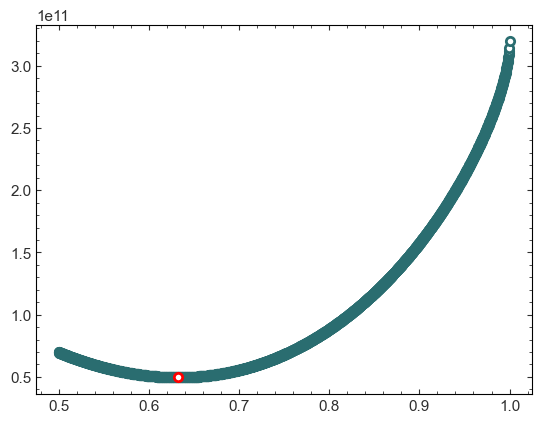

In [77]:
lattice.get_wannier()
lattice.fit_s()
plt.plot(lattice.s_vals, lattice.costs)
plt.plot(lattice.s, np.min(lattice.costs), 'ro')


In [78]:
from ipywidgets import interact

def plot_wannier(s=0.5):
    w1, w2, w3 = lattice.band_mixing(s=s)
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow((w1).real, cmap='diverging')
    axs[0].set_title('d orbital')
    axs[1].imshow((w2).real, cmap='diverging')
    axs[1].set_title('py orbital')
    axs[2].imshow((w3).real, cmap='diverging')
    axs[2].set_title('px orbital')
    plt.show()

interact(plot_wannier, s=(0,1,0.01));

interactive(children=(FloatSlider(value=0.5, description='s', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [79]:
w1, w2, w3 = lattice.band_mixing(s=lattice.s)

In [80]:
-np.sum(lattice.s * lattice.energy[0,:] * np.exp(1j*lattice.qx_vals*np.pi) + 0.5*(1-lattice.s) * lattice.energy[1,:] * np.exp(1j*lattice.qx_vals*np.pi) + 0.5*(1-lattice.s) * lattice.energy[2,:] * np.exp(1j*lattice.qx_vals*np.pi))/len(lattice.qx_vals)

## t_dd

np.complex128(0.04082204421560829+4.789047984843364e-09j)

In [81]:
-np.sqrt(lattice.s*(1-lattice.s)/2) * np.sum(np.exp(1j*lattice.thetad0) * np.exp(-1j*lattice.thetapy0)*lattice.energy[0,:] + np.exp(1j*lattice.thetad1) * np.exp(-1j*lattice.thetapy1)*lattice.energy[1,:] + np.exp(1j*lattice.thetad2) * np.exp(-1j*lattice.thetapy2)*lattice.energy[2,:])/len(lattice.qx_vals)

## t_pd

np.complex128(0.7934225791385042+0.09907976295438348j)

In [82]:
-np.sqrt((1-lattice.s)**2/4) * np.sum(np.exp(1j*lattice.thetapx0) * np.exp(-1j*lattice.thetapy0)*lattice.energy[0,:] + np.exp(1j*lattice.thetapx1) * np.exp(-1j*lattice.thetapy1)*lattice.energy[1,:] + np.exp(1j*lattice.thetapx2) * np.exp(-1j*lattice.thetapy2)*lattice.energy[2,:])/len(lattice.qx_vals)

#t_pp

np.complex128(0.2992531562829024-5.710842819705554e-12j)

In [83]:
np.sum(np.abs(w2)**4)/np.sum(np.abs(w1)**4)

# Up/U_d

np.float64(0.9866612108385288)

In [84]:
np.sum(np.abs(w1)**2*np.abs(w2)**2)/np.sum(np.abs(w1)**4)

# U_pd/U_d

np.float64(0.027658087699204362)

In [85]:
np.sum(np.abs(w1)**2*w1.conj()*w2)/np.sum(np.abs(w1)**4)


np.complex128(0.07649437535766247+0.00034646952948982207j)

In [86]:
np.sum(np.abs(w2)**2*w2.conj()*w3)/np.sum(np.abs(w1)**4)

np.complex128(0.03459623674191977-0.02778455740860428j)